In [35]:
import pandas as pd
from pandas.io import sql
import geopandas as gpd
import numpy as np
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine
import os
import dotenv
import csv
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

%matplotlib inline
pd.set_option('display.max_rows', None)

In [3]:
%load_ext dotenv
%dotenv ../.env

In [4]:
cnx = create_engine(os.getenv('EDMDB'))

In [5]:
sql.execute('''
DROP TABLE IF EXISTS dcp.lpc_yrbuilt;
''', cnx)

In [6]:
sql.execute('''
CREATE TABLE dcp.lpc_yrbuilt AS
SELECT *
FROM dcp.lpc;
''', cnx)

In [7]:
sql.execute('''
ALTER TABLE dcp.lpc_yrbuilt
ADD COLUMN no_pluto_bbl character(1) COLLATE pg_catalog."default",
ADD COLUMN yrbuilt_eq_date_high character(1) COLLATE pg_catalog."default",
ADD COLUMN date_high_eq_0 character(1) COLLATE pg_catalog."default",
ADD COLUMN numbldgs_pluto smallint,
ADD COLUMN appdate_pluto date,
ADD COLUMN cnstrct_yr_footprints bigint,
ADD COLUMN job_type character varying(12) COLLATE pg_catalog."default",
ADD COLUMN job_number integer,
ADD COLUMN status character varying(21) COLLATE pg_catalog."default",
ADD COLUMN status_dat character varying(22) COLLATE pg_catalog."default",
ADD COLUMN year_built_date_high_diff integer,
ADD COLUMN yearbuilt_pluto smallint,
ADD COLUMN year_desig varchar;
''', cnx)

In [8]:
sql.execute('''
CREATE INDEX index_lpc_yrbuilt_bbl
    ON dcp.lpc_yrbuilt USING btree
    (bbl COLLATE pg_catalog."default")
    TABLESPACE pg_default;
''', cnx)

In [9]:
sql.execute('''
CREATE INDEX index_lpc_yrbuilt_bbl_num
    ON dcp.lpc_yrbuilt USING btree
    (bbl COLLATE pg_catalog."default")
    TABLESPACE pg_default;
''', cnx)

In [10]:
sql.execute('''
CREATE INDEX index_lpc_yrbuilt_bin
    ON dcp.lpc_yrbuilt USING btree
    (bin)
    TABLESPACE pg_default;
''', cnx)

Default the "no BBL on PLUTO" flag to "Y."

In [11]:
sql.execute('''
UPDATE dcp.lpc_yrbuilt
SET no_pluto_bbl = 'Y';
''', cnx)

Then set the flag to "N" if the BBL is found on PLUTO.

In [12]:
sql.execute('''
UPDATE dcp.lpc_yrbuilt l
SET no_pluto_bbl = 'N'
FROM dcp.pluto192 p
WHERE l.bbl_num = p."BBL";
''', cnx)

Get the YearBuilt field from PLUTO.

In [13]:
sql.execute('''
UPDATE dcp.lpc_yrbuilt l
SET yearbuilt_pluto = p."YearBuilt"
FROM dcp.pluto192 p
WHERE p."BBL" = l.bbl_num;
''', cnx)

Give the "YearBuilt Equal to Date_High" flag a default value of "N"...

In [14]:
sql.execute('''
UPDATE dcp.lpc_yrbuilt
SET yrbuilt_eq_date_high = 'N';
''', cnx)

...Then set it to "Y" if YearBuilt is the same as LPC's Date_High.

In [15]:
sql.execute('''
UPDATE dcp.lpc_yrbuilt
SET yrbuilt_eq_date_high = 'Y'
WHERE yearbuilt_pluto = date_high;
''', cnx)

Give the "Date_High Equals Zero" flag a default value of "N"...

In [16]:
sql.execute('''
UPDATE dcp.lpc_yrbuilt
SET date_high_eq_0 = 'N';
''', cnx)

...Then set it to "Y" if Date_High equals zero.

In [17]:
sql.execute('''
UPDATE dcp.lpc_yrbuilt
SET date_high_eq_0 = 'Y'
WHERE date_high = 0;
''', cnx)

Add NumBldgs and AppDate from PLUTO if (1) There is a PLUTO record, and (2) YearBuilt is not equal to Date_High, and (3) Date_High is not equal to zero.

In [18]:
sql.execute('''
UPDATE dcp.lpc_yrbuilt l
SET numbldgs_pluto = p."NumBldgs",
appdate_pluto = CAST(p."APPDate" AS DATE)
FROM dcp.pluto192 p
WHERE p."BBL" = l.bbl_num
AND l.no_pluto_bbl = 'N'
AND l.yrbuilt_eq_date_high = 'N'
AND l.date_high_eq_0 = 'N';
''', cnx)

Get the construction year from DOB's Footprints table, provided it is greater than equal to 1965 (the first year a district was Landmarked).

In [19]:
sql.execute('''
UPDATE dcp.lpc_yrbuilt l
SET cnstrct_yr_footprints = f.cnstrct_yr
FROM dcp.bldg_footprints f
WHERE f.bin = l.bin
AND f.base_bbl = l.bbl
AND f.cnstrct_yr >= 1965
AND no_pluto_bbl = 'N'
AND yrbuilt_eq_date_high = 'N'
AND date_high_eq_0 = 'N';
''', cnx)

Now get the job type, job number, status, and status date from the housing database. Prior to this, you will need to have downloaded only demolition and new construction records from the Capital Planning site.

In [20]:
sql.execute('''
UPDATE dcp.lpc_yrbuilt l
SET job_type = h.job_type,
job_number = h.job_number,
status = h.status,
status_dat = h.status_dat
FROM dcp.housing_development h
WHERE l.no_pluto_bbl = 'N'
AND l.yrbuilt_eq_date_high = 'N'
AND l.date_high_eq_0 = 'N'
AND h.bin = l.bin
AND h.status_dat = (SELECT MAX(h2.status_dat) FROM dcp.housing_development h2 WHERE h2.bin = l.bin);
''', cnx)

Calculate the difference between YearBuilt and Date_High

In [23]:
sql.execute('''
UPDATE dcp.lpc_yrbuilt l
SET year_built_date_high_diff = yearbuilt_pluto - date_high
WHERE no_pluto_bbl = 'N'
AND yrbuilt_eq_date_high = 'N'
AND date_high_eq_0 = 'N';
''', cnx)

We are presently getting the Landmarks designation date in preference order. Here we get all designation dates where there is only a single match on the "Designated and Calendared" table.

In [22]:
sql.execute('''
UPDATE dcp.lpc_yrbuilt l
SET year_desig = CAST(EXTRACT(YEAR FROM b.date_desda) AS VARCHAR)
FROM dcp.lpc_dc_buildings_sites b
WHERE b.bbl IN
(SELECT b.bbl
FROM dcp.lpc_dc_buildings_sites b
GROUP BY b.bbl
HAVING COUNT(*) = 1)
AND l.bbl = b.bbl
AND l.no_pluto_bbl = 'N'
AND l.yrbuilt_eq_date_high = 'N'
AND l.date_high_eq_0 = 'N';
''', cnx)

For lots that have been landmarked more than once, we take the dates in preference order: (1) Individual Landmark, (2) Historic District, (3) Scenic Landmark, (4) Interior Landmark. See the next several cells. Note that this may have to change, it may be that we are only interested in Historic Districts.

In [26]:
sql.execute('''
UPDATE dcp.lpc_yrbuilt l
SET year_desig = CAST(EXTRACT(YEAR FROM b.date_desda) AS VARCHAR)
FROM dcp.lpc_dc_buildings_sites b
WHERE year_desig IS NULL
AND b.bbl = l.bbl
AND l.numbldgs_pluto = 1
AND b.lm_type = 'Individual Landmark'
AND l.no_pluto_bbl = 'N'
AND l.yrbuilt_eq_date_high = 'N'
AND l.date_high_eq_0 = 'N';
''', cnx)

In [27]:
sql.execute('''
UPDATE dcp.lpc_yrbuilt l
SET year_desig = CAST(EXTRACT(YEAR FROM b.date_desda) AS VARCHAR)
FROM dcp.lpc_dc_buildings_sites b
WHERE year_desig IS NULL
AND b.bbl = l.bbl
AND l.numbldgs_pluto = 1
AND b.lm_type = 'Historic District'
AND l.no_pluto_bbl = 'N'
AND l.yrbuilt_eq_date_high = 'N'
AND l.date_high_eq_0 = 'N';
''', cnx)

In [28]:
sql.execute('''
UPDATE dcp.lpc_yrbuilt l
SET year_desig = CAST(EXTRACT(YEAR FROM b.date_desda) AS VARCHAR)
FROM dcp.lpc_dc_buildings_sites b
WHERE year_desig IS NULL
AND b.bbl = l.bbl
AND l.numbldgs_pluto = 1
AND b.lm_type = 'Scenic Landmark'
AND l.no_pluto_bbl = 'N'
AND l.yrbuilt_eq_date_high = 'N'
AND l.date_high_eq_0 = 'N';
''', cnx)

In [29]:
sql.execute('''
UPDATE dcp.lpc_yrbuilt l
SET year_desig = CAST(EXTRACT(YEAR FROM b.date_desda) AS VARCHAR)
FROM dcp.lpc_dc_buildings_sites b
WHERE year_desig IS NULL
AND b.bbl = l.bbl
AND l.numbldgs_pluto = 1
AND b.lm_type = 'Interior Landmark'
AND l.no_pluto_bbl = 'N'
AND l.yrbuilt_eq_date_high = 'N'
AND l.date_high_eq_0 = 'N';
''', cnx)

Create a dataframe from the lpc_yrbuilt table

In [ ]:
df_lpc_yrbuilt = pd.read_sql_query('''
SELECT *
FROM dcp.lpc_yrbuilt;
''', cnx)

Create a CSV file from the final dataframe. Freeze the header in Excel, make any other desired formatting changes, and give this to Lynn.

In [ ]:
df_lpc_yrbuilt.to_csv("../output/YearBuilt_LPC_Enhanced_File.csv", index=False)

Set your background color, fonts, and font sizes for the histogram. This histogram will have to be modified once we have before and after values. The idea will be to have two YearBuilt distributions in the plot.

In [ ]:
sns.set(rc={'axes.facecolor':'#dddddd'})
SMALL_SIZE = 8
MEDIUM_SMALL_SIZE = 10
MEDIUM_SIZE = 12
MEDIUM_LARGE_SIZE = 14
BIGGER_SIZE = 16
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Inconsolata']
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_LARGE_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["figure.figsize"] = [16, 10]

Get full range of decades for histogram.

In [ ]:
df_decades = pd.read_sql_query('''
SELECT CAST("YearBuilt" / 10 AS VARCHAR) || '0s' AS decade
FROM dcp.pluto192
WHERE "YearBuilt" <> 0
AND "YearBuilt" > 1659
ORDER BY 1;
''', cnx)
df_decades.to_csv("../data/decades_19v2.csv", index=False)

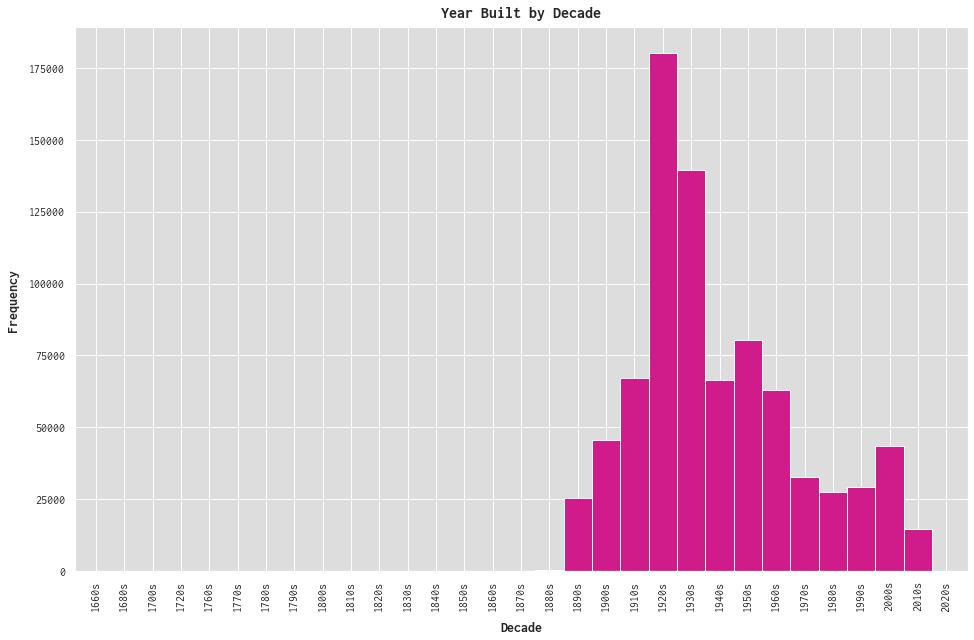

In [60]:
with open('../data/decades_19v2.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader)
    decade_hold = ''
    read_count = 0
    decades = []

    for row in csv_reader:
        decades.append(row[0])

df = pd.DataFrame({'Decade': decades})
df.groupby('Decade', as_index=False).size().plot(kind='bar', color="#d01c8b", width=1)
plt.xlabel('Decade', fontweight='bold', labelpad=10)
plt.ylabel('Frequency', fontweight='bold', labelpad=10)
plt.title('Year Built by Decade', fontweight='bold', pad=10)
plt.show()

Weird years.

In [40]:
strange_years = pd.read_sql_query('''
SELECT CAST("BBL" AS VARCHAR),
"Address",
"YearBuilt"
FROM dcp.pluto192
WHERE ("YearBuilt" < 1650 OR "YearBuilt" > 2020)
AND "YearBuilt" <> 0
ORDER BY "YearBuilt";
''', cnx)
strange_years

,BBL,Address,YearBuilt
0,1013730003,465 MAIN STREET,103
1,1013730002,475 MAIN STREET,103
2,1013730065,8 NORTH LOOP ROAD,115
3,1013730035,2 WEST LOOP ROAD,115
4,2041690018,1765 CROSBY AVENUE,116
5,1013730050,900 MAIN STREET,900
6,1012600004,1150 AVENUE OF THE AMER,914
7,1012620034,562 5 AVENUE,920
8,2048490082,3973 BRONXWOOD AVENUE,925
9,1018190002,FDR DRIVE,925
